# Deterministic case: DeePC vs. SPC

This notebook is used to create the results for **Figure 2** in our paper.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as sio
from casadi import *
from casadi.tools import *

In [12]:
# Random seed:
np.random.seed(1234)

In [13]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6

##  System description


We investigate a simple LTI system in the form of:
\begin{align}
x_{k+1} &= Ax_k + Bu_k\\
y_k &= Cx_k+Du_k,
\end{align}

with $x \in \mathbb{R}^n$ (states), $u\in \mathbb{R}^m$ (inputs), $y\in \mathbb{R}^p$ (measurements) and system matrices $A \in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n\times m}$, $C \in \mathbb{R}^{p\times n}$ and $D \in \mathbb{R}^{p\times m}$.

The investigated system, displayed below, is a triple-mass-spring system (rotating discs) with two stepper motors ($m=2$) attached to the outermost discs via additional springs. These disc angles are the measured output of the system ($p=3$). The system has a total of $n=8$ states.

<img src="sources/triple_mass_spring.pdf" width=40%/>

To simulate the system, we created a very simple helper class, that keeps the current state and stores the past sequences of inputs, states and outputs.

We import the system class with:

In [14]:
import sys
# Add subfolder sources to path.
sys.path.append('./sources')
# Import class 'System' from file System.py
from System import System

Import system matrices, $A,B,C,D$ and create instance of ``System``:

In [15]:
sys_dc = sio.loadmat('./sources/sys_dc.mat')
A = sys_dc['A_dc']
B = sys_dc['B_dc']
C = sys_dc['C']
D = sys_dc['D']

sys = System(A,B,C,D)

## Investigating the System

We create a helper function that creates an input signal reminiscent of PRBS (but with varying amplitude). 

In [16]:
def random_u(u0, switch_prob=0.5, u_max=np.pi):
    # Hold the current value with switch_prob chance or switch to new random value.
    u_next = (0.5-np.random.rand(2,1))*u_max # New candidate value.
    switch = np.random.rand() >= (1-switch_prob) # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

Simulate and plot system response.

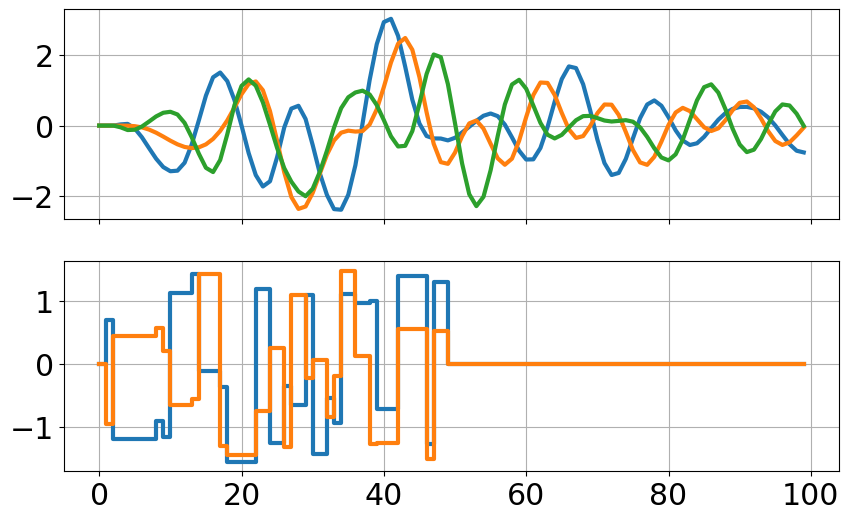

In [17]:
sys.reset()

u0 = np.zeros((2,1))
for k in range(100):
    if k<50:
        u0 = random_u(u0)
    else:
        u0 = np.zeros((2,1))
    sys.make_step(u0)

fig, ax = plt.subplots(2,1,figsize=(10,6), sharex = True)
ax[0].plot(sys.time,sys.y)
ax[1].step(sys.time,sys.u)

# DeePC vs. SPC

## Data collection

Both methods require a measured system response for persistantly exciting input data, depending on the parameters:
$T_{\text{ini}}$ and $N$.

The total number of measured sequences depends on these parameters and must exceed the thresholds given by Assumption 1, 2 and 3 in the paper. 

In the particular example with $T_{\text{ini}}=4$ and $N=40$, we have that $T\geq  96$.

We choose $T\geq  150$.

In [18]:
T_ini = 4
N = 40

L = T_ini + N

T = 150

n_u = sys.n_u
n_y = sys.n_y

Create matrices $U_L$ and $Y_L$ according to (2) in the paper. Note that we construct the data matrices which are neither Hankel nor Page matrices. Instead we "measure" independent sequences each with **random initial state** to satisfy Assumption 3. Please see for yourself what happens if the intial state is e.g. constant at zero.

In [19]:
U_L = []
Y_L = []

u0 = np.zeros((2,1))

for k in range(T):
    x0 = np.random.randn(8,1)
    #x0 = np.zeros((8,1))
    sys.reset(x0)
      
    for k in range(L):
        u0 = random_u(u0)
        sys.make_step(u0)
        
    U_L.append(sys.u.reshape(-1,1))
    Y_L.append(sys.y.reshape(-1,1))
    
U_L = np.concatenate(U_L,axis=1)
Y_L = np.concatenate(Y_L,axis=1)
print(f"U_L shape: {U_L.shape}")
print(f"Rank: {np.linalg.matrix_rank(U_L)}")

assert np.linalg.matrix_rank(U_L) == U_L.shape[0], "not persistantly exciting."

U_L shape: (88, 150)
Rank: 88


According to (3) in the paper, we divide the input/output data in two parts such that:

\begin{equation}
U_L = \left[
\begin{array}{c}
U_{T_\text{ini}}\\
U_{N}
\end{array}
\right],\ 
Y_L = \left[
\begin{array}{c}
Y_{T_\text{ini}}\\
Y_{N}
\end{array}
\right].
\end{equation}

In [20]:
U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)

Here are some of the sampled trajectories:

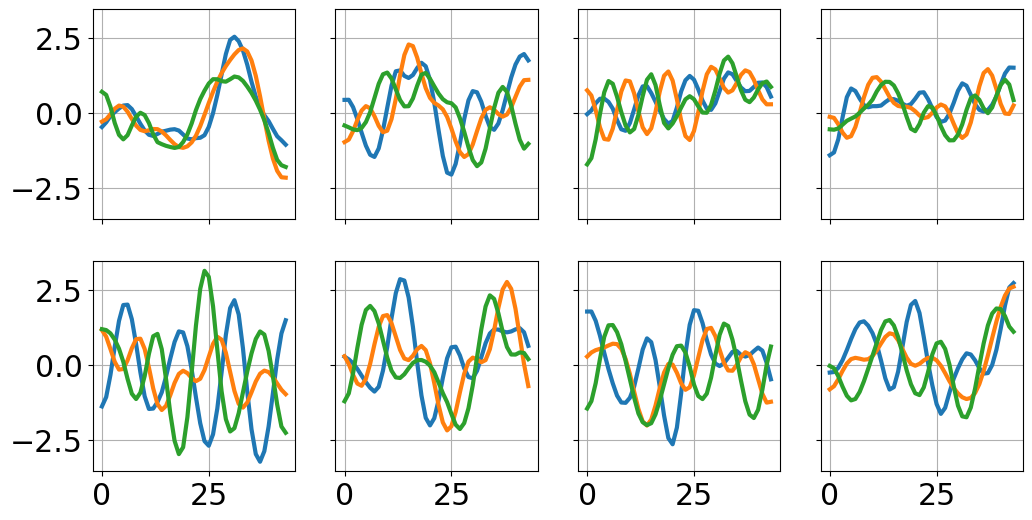

In [21]:
n_traj = 8
n_rows = 2

fig, ax = plt.subplots(2, n_traj//n_rows, figsize=(12,6), sharex=True, sharey=True)

for k in range(n_traj):
    i,j = k % n_rows, k//n_rows
    ax[i,j].plot(Y_L[:,k].reshape(-1,n_y))

## Subspace predictive control

For SPC, we first identify $P^*$ from the least-squares problem:

\begin{equation}
%
	 P^* = \arg\ \min_{ P} \ \| P
	\underbrace{
	\left[\begin{array}{c}
    Y_{T_\text{ini}}\\
	U_{T_\text{ini}}\\
	U_N\\
	\end{array}
	\right]}_M
	- 
	Y_N
	\|_F^2.
\end{equation}

with the Moore-Penrose inverse, such that:

\begin{equation}
 P^* = Y_N M^\dagger,
\end{equation}

In [22]:
M = np.concatenate((Y_Tini, U_L))

P = Y_N@np.linalg.pinv(M)

Let's see how $P^*$ looks like:

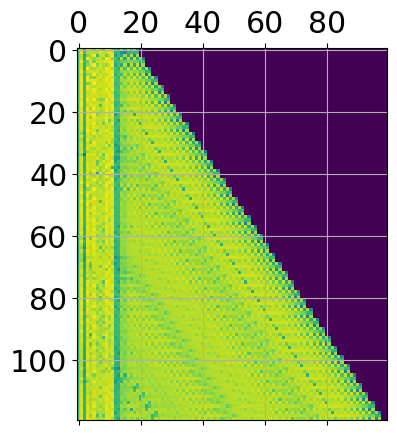

In [23]:
plt.matshow(np.log(np.abs(P)+1e-10))

We expected this triangular shape, because there is no relationship between outputs and their respective future inputs. Also the block to the left shows that the entire sequence depends on the initial measurements.

### Simulation with the multi-step model

To validate the multi-step model, we simulate $N$ steps into the future for given initial inputs/outputs ($y_{T_{\text{ini}}},\  u_{T_{\text{ini}}}$) and a random future input-sequence ($u_N$).

In [24]:
y_Tini = sys.y[-T_ini:,:].reshape(-1,1)
u_Tini = sys.u[-T_ini:,:].reshape(-1,1)

u0 = np.zeros((2,1))

for k in range(N):
    u0 = random_u(u0)
    sys.make_step(u0)
    
u_N = sys.u[-N:,:].reshape(-1,1)

b = np.concatenate((y_Tini, u_Tini, u_N),axis=0)

y_true = sys.y[-N:,:]
y_msm = (P@b).reshape(-1,n_y)

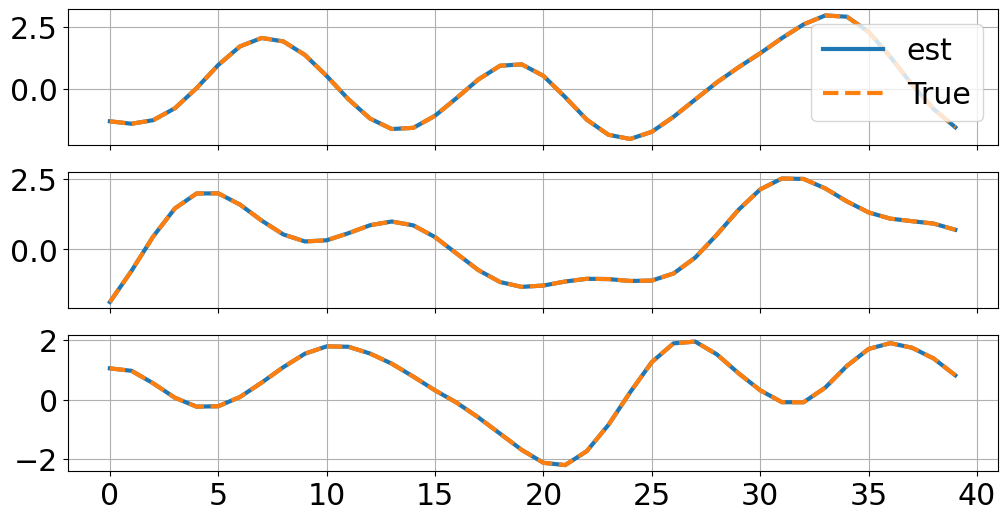

In [25]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(12,6))

for k in range(n_y):
    ax[k].plot(y_msm[:,k], label='est')
    ax[k].plot(y_true[:,k], '--', label='True')
    
ax[0].legend()

To quantify the prediction accuracy, we compute:

In [26]:
np.linalg.norm(y_msm-y_true)

7.179148670204289e-13

which shows that both results are nearly identical.

### SPC: Building the optimizer

We want to implement the following problem:

\begin{equation}
	\begin{aligned}
		\min_{u_N,y_N}\quad &\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)\\
		\text{s.t.}\quad & 
        y_N =  P^*
        \left[\begin{array}{c}
        y_{T_\text{ini}}\\
        u_{T_\text{ini}}\\
        u_{N}\\
        \end{array}\right],
        \\
		&u_k \in \mathbb{U},\ \forall k\in \{1,\dots,N\},	\\
		&y_k \in \mathbb{Y},\ \forall k\in \{1,\dots,N\}.	\\
	\end{aligned}
\end{equation}

The results in the paper are obtained with $\mathbb{U}=[-0.7,0.7]$ for both motors.

We build the optimizer using [CasADi](https://web.casadi.org) and profit from their ``struct_symSX`` class, which allows to create symbolic variables within a structure for easier indexing. This [tutorial](http://casadi.sourceforge.net/v2.0.0/tutorials/tools/structure.pdf) explains the use of structures for CasADi in Python.

In [27]:
# Create optimization variables:
opt_x_spc = struct_symMX([
    entry('y_N', shape=(n_y), repeat=N),
    entry('u_N', shape=(n_u), repeat=N),
])

# Create parameters of the optimization problem
opt_p_spc = struct_symMX([
    entry('u_Tini', shape=(n_u), repeat=T_ini),
    entry('y_Tini', shape=(n_y), repeat=T_ini),
])

# Create numerical instances of the structures (holding all zeros as entries)
opt_x_num_spc = opt_x_spc(0)
opt_p_num_spc = opt_p_spc(0)

In [28]:
# Create the objective:
obj = 0
for k in range(N):
    obj += sum1(opt_x_spc['y_N',k]**2)+0.1*sum1(opt_x_spc['u_N', k]**2)


# Create the constraints:
b = vertcat(*opt_p_spc['y_Tini'], *opt_p_spc['u_Tini'], *opt_x_spc['u_N'])
y_N = vertcat(*opt_x_spc['y_N'])
cons = P@b-y_N


# Create lower and upper bound structures and set all values to plus/minus infinity.
lbx_spc = opt_x_spc(-np.inf)
ubx_spc = opt_x_spc(np.inf)

# Set only bounds on u_N
lbx_spc['u_N'] = -0.7
ubx_spc['u_N'] = 0.7


# Create Optim
nlp = {'x':opt_x_spc, 'f':obj, 'g':cons, 'p':opt_p_spc}
S_spc = nlpsol('S', 'ipopt', nlp)

## DeePC

### Building the optimizer

We now proceed to implement DeePC using the same tools. The optimization problem is given as:

\begin{equation}
	\begin{aligned}
	\min_{g,u_N, y_N}\quad &f(g,u_N, y_N)\\
	\text{s.t.}\quad & 
    	\left[\begin{array}{c}
	Y_{T_\text{ini}}\\
	U_{T_\text{ini}}\\
	U_{N}\\
	Y_{N}
	\end{array}\right] g 
	= 
	\left[\begin{array}{c}
	y_{T_\text{ini}}\\
	u_{T_\text{ini}}\\
	u_{N}\\
	y_{N}
	\end{array}\right],
    \\
	&u_k \in \mathbb{U}\ \forall k\in\{1,\dots,N\},	\\
	&y_k \in \mathbb{Y}\ \forall k\in\{1,\dots,N\}, \\
	\end{aligned}
\end{equation}

In [29]:
opt_x_dpc = struct_symMX([
    entry('g', shape=(T)),
    entry('u_N', shape=(n_u), repeat=N),
    entry('y_N', shape=(n_y), repeat=N)
])

opt_p_dpc = struct_symMX([
    entry('u_Tini', shape=(n_u), repeat=T_ini),
    entry('y_Tini', shape=(n_y), repeat=T_ini),
])

opt_x_num_dpc = opt_x_dpc(0)
opt_p_num_dpc = opt_p_dpc(0)

In [30]:
# Create the objective:
obj = 0
for k in range(N):
    obj += sum1(opt_x_dpc['y_N',k]**2)+0.1*sum1(opt_x_dpc['u_N', k]**2)

    
# Create the constraints
A = vertcat(Y_Tini, U_Tini, U_N, Y_N)
b = vertcat(*opt_p_dpc['y_Tini'], *opt_p_dpc['u_Tini'], *opt_x_dpc['u_N'], *opt_x_dpc['y_N'])

cons = A@opt_x_dpc['g']-b



# Create lower and upper bound structures and set all values to plus/minus infinity.
lbx_dpc = opt_x_dpc(-np.inf)
ubx_dpc = opt_x_dpc(np.inf)


# Set only bounds on u_N
lbx_dpc['u_N'] = -0.7
ubx_dpc['u_N'] = 0.7

# Create Optim
nlp = {'x':opt_x_dpc, 'f':obj, 'g':cons, 'p':opt_p_dpc}
S_dpc = nlpsol('S', 'ipopt', nlp)

# Open-loop comparison

We start with a comparison of the open-loop prediction for some arbitrary intial condition (not at rest).

In [31]:
np.random.seed(12)
sys.reset()

# Excitement
n_exc = 20
u0 = np.zeros((2,1))
for k in range(n_exc):
    u0 = random_u(u0)
    sys.make_step(u0)

In [32]:
y_Tini = sys.y[-T_ini:,:]
u_Tini = sys.u[-T_ini:,:]

Assign these initial conditions to the parameter structures for both optimizers

In [33]:
opt_p_num_spc['y_Tini'] = vertsplit(y_Tini)
opt_p_num_spc['u_Tini'] = vertsplit(u_Tini)

opt_p_num_dpc['y_Tini'] = vertsplit(y_Tini)
opt_p_num_dpc['u_Tini'] = vertsplit(u_Tini)

## Solve SPC problem

In [34]:
r = S_spc(p=opt_p_num_spc,lbx=lbx_spc,ubx=ubx_spc,lbg=0,ubg=0)
# Extract solution
opt_x_num_spc.master = r['x'] 
u_N_spc = horzcat(*opt_x_num_spc['u_N']).full().T
y_N_spc = horzcat(*opt_x_num_spc['y_N']).full().T


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9720
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality c

In [35]:
r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx_dpc, ubx=ubx_dpc)
# Extract solution
opt_x_num_dpc.master = r['x'] 
u_N_dpc = horzcat(*opt_x_num_dpc['u_N']).full().T
y_N_dpc = horzcat(*opt_x_num_dpc['y_N']).full().T

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    33200
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:      220
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.19e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## Comparison of open-loop prediction

Text(0, 0.5, 'motor \n angle [rad]')

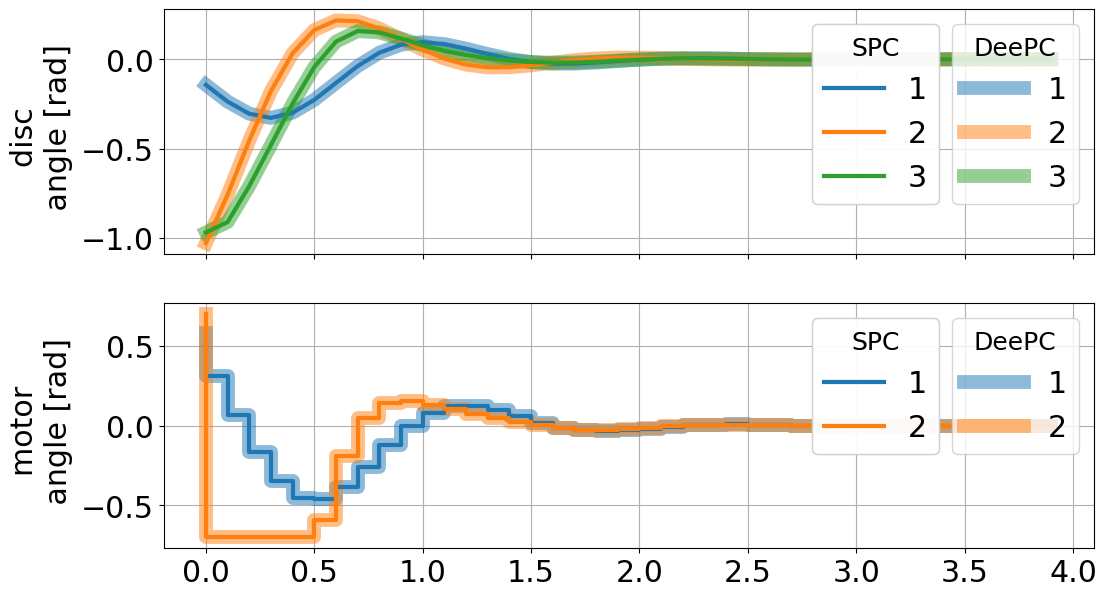

In [36]:
fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)

t = np.arange(N)*0.1
y_dpc_lines = ax[0].plot(t,y_N_dpc, linewidth=10, alpha=.5)
ax[0].set_prop_cycle(None)
y_msm_lines = ax[0].plot(t,y_N_spc)
u_dpc_lines = ax[1].step(t,u_N_dpc,linewidth=10, alpha=.5)
ax[1].set_prop_cycle(None)
u_msm_lines = ax[1].step(t,u_N_spc)

plt.sca(ax[0])
ax[0].add_artist(plt.legend(y_dpc_lines,'123', title ='DeePC', loc=1))
ax[0].add_artist(plt.legend(y_msm_lines, '123', title='SPC', loc=1, bbox_to_anchor=(0.85, 1)))
ax[0].set_ylabel('disc \n angle [rad]')


plt.sca(ax[1])
ax[1].add_artist(plt.legend(u_dpc_lines,'12', title ='DeePC', loc=1))
ax[1].add_artist(plt.legend(u_msm_lines, '12', title='SPC', loc=1, bbox_to_anchor=(0.85, 1)))
ax[1].set_ylabel('motor \n angle [rad]')

We can also compare the norm of the difference of the obtained solutions:

In [37]:
np.linalg.norm(y_N_dpc-y_N_spc)

8.218970971101565e-09

In [38]:
np.linalg.norm(u_N_dpc-u_N_spc)

1.8042745601877945e-08

which shows that they are identical.

# Closed-loop comparison:

## DeePC

We start by resetting the system and applying a (pseudo) random input sequence. 
By fixing the random seed to 12 (why not 12?), the initilization is repeatable. 

In [39]:
np.random.seed(12)
sys.reset()

# Excitement
n_exc = 20
u0 = np.zeros((2,1))
for k in range(n_exc):
    u0 = random_u(u0)
    sys.make_step(u0)

We then proceed with the closed-loop control experiment and store the results in the ``res_deePC`` dict.
The output of this code cell is surpressed. with ``%%capture``. 

In [40]:
%%capture
# Control
cost = []
for k in range(60):
    u0 = np.zeros((2,1))
    
    y_Tini = sys.y[-T_ini:,:]
    u_Tini = sys.u[-T_ini:,:] 

    opt_p_num_dpc['y_Tini'] = vertsplit(y_Tini)
    opt_p_num_dpc['u_Tini'] = vertsplit(u_Tini)
    r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx_dpc, ubx=ubx_dpc)
    opt_x_num_dpc.master = r['x']
    u0 = opt_x_num_dpc['u_N',0].full()
    y0 = sys.make_step(u0)
    
    cost.append(.1*u0.T@u0+y0.T@y0)
    
res_deePC = {'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost':np.concatenate(cost)}

## SPC

Similarly as above, we first initilize the sytem.

In [41]:
np.random.seed(12)
sys.reset(x0=np.zeros((8,1)))

# Excitement
n_exc = 20
u0 = np.zeros((2,1))
for k in range(n_exc):
    u0 = random_u(u0)
    sys.make_step(u0)

Control-loop for MPC based on multi-step model:

In [42]:
%%capture
# Control
cost = []
for k in range(60):
    u0 = np.zeros((2,1))
    
    y_Tini = sys.y[-T_ini:,:]
    u_Tini = sys.u[-T_ini:,:] 

    opt_p_num_spc['y_Tini'] = vertsplit(y_Tini)
    opt_p_num_spc['u_Tini'] = vertsplit(u_Tini)
    r = S_spc(p=opt_p_num_spc, lbg=0, ubg=0, lbx=lbx_spc, ubx=ubx_spc)
    opt_x_num_spc.master = r['x']
    u0 = opt_x_num_spc['u_N',0].full()
    y0 = sys.make_step(u0)
    
    cost.append(.1*u0.T@u0+y0.T@y0)
    
res_spc = {'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost':np.concatenate(cost)}

**Figure 2** in paper.

Closed-loop trajectories of the mass-spring-system. Regulation after some initial excitation. Comparison of DeePC  and SPC with deterministic data.

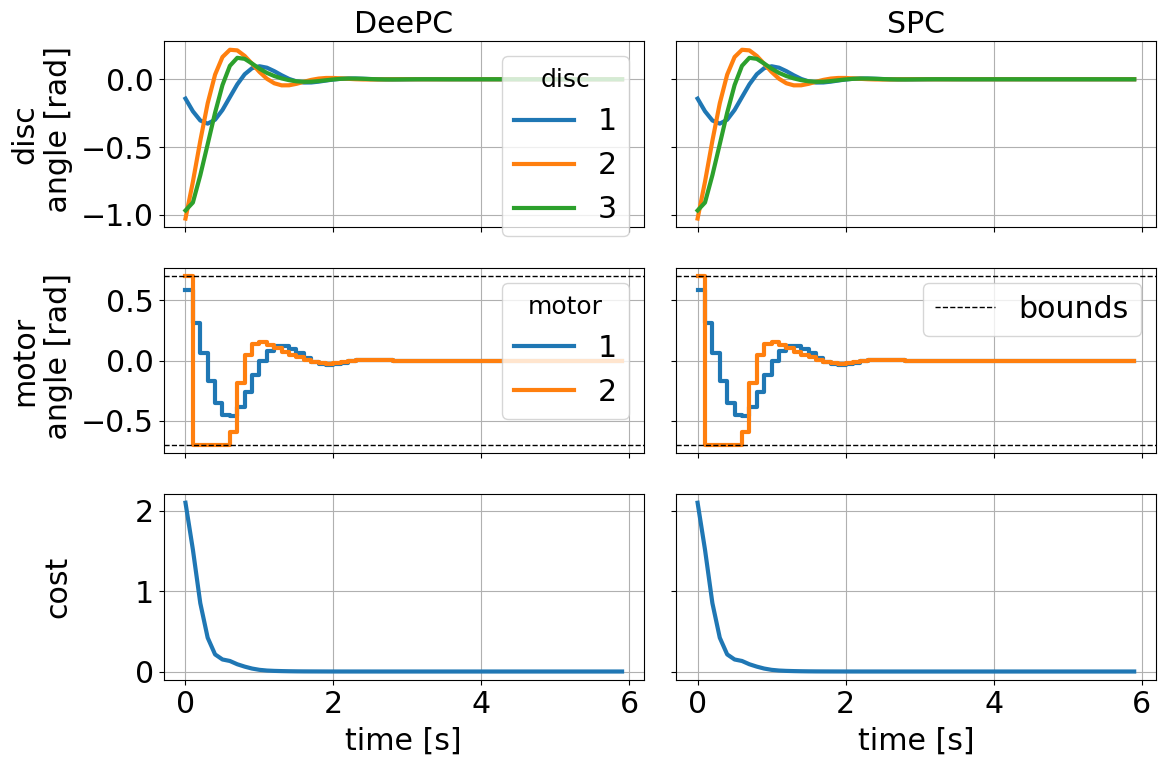

In [43]:
fig, ax = plt.subplots(3,2,figsize=(12,8),sharex=True, sharey='row')

t = np.arange(60)*0.1

ax[0,0].set_title('DeePC')
disc_lines = ax[0,0].plot(t,res_deePC['y'])
motor_lines = ax[1,0].step(t,res_deePC['u'],where='post')
ax[2,0].plot(t,res_deePC['cost'])

ax[0,1].set_title('SPC')
ax[0,1].plot(t,res_spc['y'])
ax[1,1].step(t,res_spc['u'],where='post')
ax[2,1].plot(t,res_spc['cost'])

ax[0,0].set_ylabel('disc\n angle [rad]')
ax[1,0].set_ylabel('motor\n angle [rad]')
ax[2,0].set_ylabel('cost')

cons_line = ax[1,0].axhline(-0.7,linestyle='--', color='k',linewidth=1)
ax[1,0].axhline(0.7,linestyle='--', color='k',linewidth=1)
ax[1,1].axhline(-0.7,linestyle='--', color='k',linewidth=1)
ax[1,1].axhline(0.7,linestyle='--', color='k',linewidth=1)

ax[0,0].legend(disc_lines,'123', title ='disc', loc=1)
ax[1,0].legend(motor_lines,'12', title ='motor', loc=1)
ax[1,1].legend([cons_line],['bounds'])

ax[2,0].set_xlabel('time [s]')
ax[2,1].set_xlabel('time [s]')

fig.align_ylabels()
fig.align_xlabels()
fig.tight_layout()
plt.show()

To quantify the similarity we look at the difference of the cost:

In [44]:
np.sum(res_spc['cost'])-np.sum(res_deePC['cost'])

-3.5361047423521086e-11

The overall cost in this scenario is:

In [45]:
np.sum(res_spc['cost'])

5.61684717377986